# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into utility `.py` files.

## Usage

I have expanded this notebook from to present how I'm using this information. It contains descriptions that you may find not that needed after initial reading. Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the logs may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Permissions

Depending on where you are downloading the data from, you will need some permissions:
* Access to CloudWatch log streams
* Access to S3 bucket to reach the log files

## Installs and setups

If you are using an AWS SageMaker Notebook to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [153]:
#Make sure you have deepracer-utils >= 0.9

#import sys

#!{sys.executable} -m pip install --upgrade deepracer-utils

## Imports

Run the imports block below:

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown, track_meta
from deepracer.logs import \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    ActionBreakdownUtils as abu, \
    DeepRacerLog

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [155]:
pip install plotly

  Using cached https://files.pythonhosted.org/packages/9f/16/c63412aec59219142b541011524417ef1c1c226e4a5ed2eb1cd808cd1a2b/plotly-5.6.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d9/5a/e7c31adbe875f2abbb91bd84cf2dc52d792b5a01506781dbcf25c91daf11/six-1.16.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/a5/f86bc8d67c979020438c8559cc70cfe3a1643fd160d35e09c9cca6a09189/tenacity-8.0.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [156]:
import plotly.express as px

## Get the logs

Depending on which way you are training your model, you will need a slightly different way to load the data. 

**AWS DeepRacer Console**

The logs can be downloaded from the training page. Once you download them, extract the archive into logs/[training-name] (just like logs/sample-logs)

**DeepRacer for Cloud**
    
If you're using local training, just point at your model's root folder in the minio bucket. If you're using any of the cloudy deployments, download the model folder to local and point at it.

**Deepracer for dummies/Chris Rhodes' Deepracer/ARCC Deepracer or any training solution other than the ones above, read below**

This notebook has been updated to support the most recent setups. Most of the mentioned projects above are no longer compatible with AWS DeepRacer Console anyway so do consider moving to the ones actively maintained.
    

In [157]:
model_logs_root = '/home/techis/deepracer-for-cloud/data/minio/bucket/rl-deepracer-2'
log = DeepRacerLog(model_logs_root)

# load logs into a dataframe
log.load()

try:
    pprint(log.agent_and_network())
    print("-------------")
    pprint(log.hyperparameters())
    print("-------------")
    pprint(log.action_space())
except Exception:
    print("Robomaker logs not available")

df = log.dataframe()

Robomaker logs not available


In [158]:
logs = [('/home/techis/deepracer-for-cloud/data/logs/robo3.log', 'sim-sample')]
bulk = slio.load_a_list_of_logs(logs)
bulk=pd.DataFrame(bulk)

In [159]:
df.head()

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode
0,0,1.0,0.322574,2.691129,-83.997356,15.0,3.0,3,0.0,False,True,0.606669,1,23.118222,36.553,prepare,0.0,0,0,0
1,0,2.0,0.322497,2.691373,-84.006075,-15.0,3.0,1,1.0,False,True,0.605583,1,23.118222,36.605,in_progress,0.0,0,0,0
2,0,3.0,0.325440,2.684613,-83.473136,-30.0,2.0,0,0.8,False,True,0.635991,1,23.118222,36.659,in_progress,0.0,0,0,0
3,0,4.0,0.325739,2.667871,-83.839073,0.0,4.0,2,1.0,False,True,0.708236,1,23.118222,36.707,in_progress,0.0,0,0,0
4,0,5.0,0.326850,2.616956,-84.861197,0.0,4.0,2,1.0,False,True,0.926952,1,23.118222,36.781,in_progress,0.0,0,0,0


In [160]:
df.head(30)

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode
0,0,1.0,0.322574,2.691129,-83.997356,15.0,3.0,3,0.0000,False,True,0.606669,1,23.118222,36.553,prepare,0.0,0,0,0
1,0,2.0,0.322497,2.691373,-84.006075,-15.0,3.0,1,1.0000,False,True,0.605583,1,23.118222,36.605,in_progress,0.0,0,0,0
2,0,3.0,0.325440,2.684613,-83.473136,-30.0,2.0,0,0.8000,False,True,0.635991,1,23.118222,36.659,in_progress,0.0,0,0,0
3,0,4.0,0.325739,2.667871,-83.839073,0.0,4.0,2,1.0000,False,True,0.708236,1,23.118222,36.707,in_progress,0.0,0,0,0
4,0,5.0,0.326850,2.616956,-84.861197,0.0,4.0,2,1.0000,False,True,0.926952,1,23.118222,36.781,in_progress,0.0,0,0,0
5,0,6.0,0.327394,2.598034,-85.185524,15.0,3.0,3,1.0000,False,True,1.008314,2,23.118222,36.868,in_progress,0.0,0,0,0
6,0,7.0,0.333851,2.521548,-85.178265,0.0,4.0,2,1.0000,False,True,1.337390,2,23.118222,36.923,in_progress,0.0,0,0,0
7,0,8.0,0.337988,2.458818,-85.457389,15.0,3.0,3,1.0000,False,True,1.607360,2,23.118222,37.008,in_progress,0.0,0,0,0
8,0,9.0,0.360383,2.299847,-83.474442,15.0,3.0,3,1.0000,False,True,2.295971,4,23.118222,37.057,in_progress,0.0,0,0,0
9,0,10.0,0.363014,2.286715,-83.207750,-15.0,3.0,1,1.0000,False,True,2.353881,4,23.118222,37.113,in_progress,0.0,0,0,0


## Load waypoints for the track you want to run analysis on

The track waypoint files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below.

The naming of the tracks is not super consistent. The ones that we already know have been mapped to their official names in the track_meta dictionary.

Some npy files have an 'Eval' suffix. One of the challenges in the past was that the evaluation tracks were different to physical tracks and we have recreated them to enable evaluation. Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [161]:
tu = TrackIO()

for track in tu.get_tracks():
    print("{} - {}".format(track, track_meta.get(track[:-4], "I don't know")))

2022_summit_speedway.npy - I don't know
AWS_track.npy - I don't know
Albert.npy - Yun Speedway
AmericasGeneratedInclStart.npy - Badaal Track
Aragon.npy - Stratus Loop
Austin.npy - American Hills Speedway
Belille.npy - Cumulo Turnpike
Bowtie_track.npy - Bowtie Track
Canada_Eval.npy - Toronto Turnpike Eval
Canada_Training.npy - Toronto Turnpike Training
China_eval_track.npy - Shanghai Sudu Eval
China_track.npy - Shanghai Sudu Training
FS_June2020.npy - Fumiaki Loop
H_track.npy - H track
July_2020.npy - Roger Raceway
LGSWide.npy - SOLA Speedway
London_Loop_Train.npy - I don't know
Mexico_track.npy - Cumulo Carrera Training
Mexico_track_eval.npy - Cumulo Carrera Eval
Monaco.npy - European Seaside Circuit
New_York_Eval_Track.npy - Empire City Eval
New_York_Track.npy - Empire City Training
Oval_track.npy - Oval Track
Singapore.npy - Asia Pacific Bay Loop
Spain_track.npy - Circuit de Barcelona-Catalunya
Straight_track.npy - Straight track
Tokyo_Training_track.npy - Kumo Torakku Training
Vegas

Now let's load the track:

In [162]:
# We will try to guess the track name first, if it 
# fails, we'll use the constant in quotes

try:
    track_name = log.agent_and_network()["world"]
except Exception as e:
    track_name = "reInvent2019_track"


track: Track = tu.load_track(track_name)

#pu.plot_trackpoints(track)

Loaded 155 waypoints


## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:

* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it
* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.

#### Progress per Iteration

This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.

#### Total reward per episode

This graph has been taken from the orignal notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.

#### Mean completed lap times per iteration

Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:

#### Completion rate per iteration

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of deviding amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.

The higher the value, the more stable the model is on a given track.

new reward not found, using reward as its values
Number of episodes =  999
Number of iterations =  49


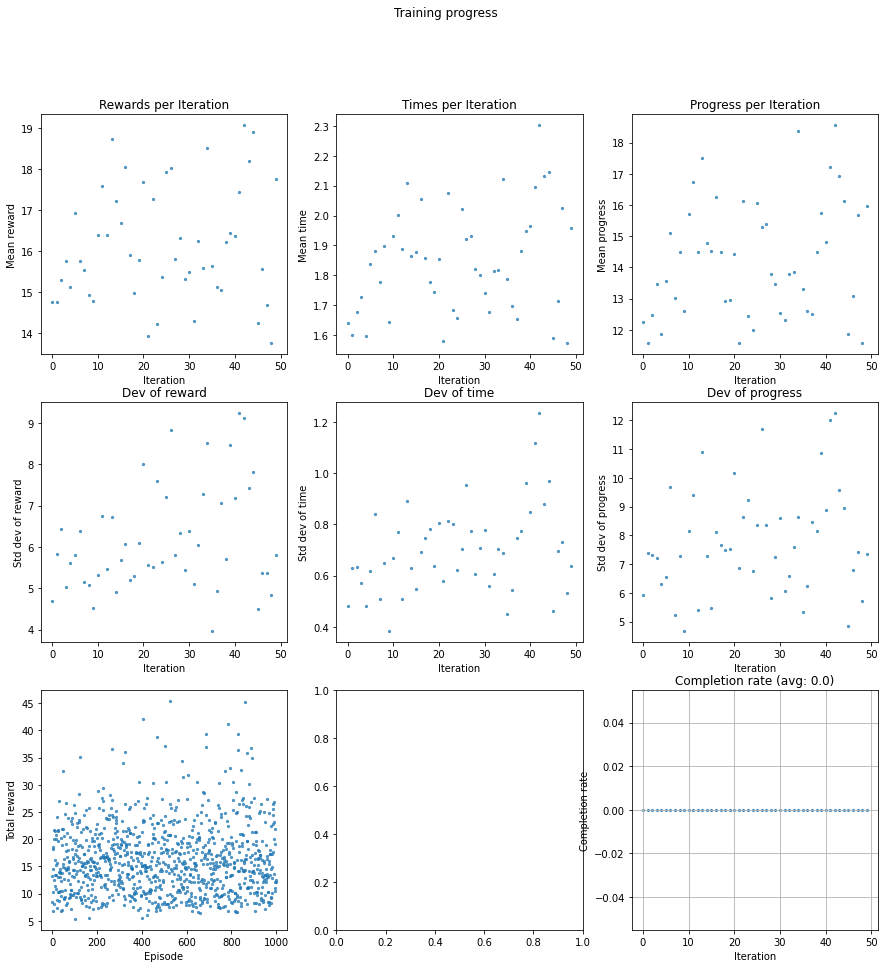

<Figure size 432x288 with 0 Axes>

In [163]:
simulation_agg = au.simulation_agg(df)

au.analyze_training_progress(simulation_agg, title='Training progress')

### Stats for all laps

Previous graphs were mainly focused on the state of training with regards to training progress. This however will not give you a lot of information about how well your reward function is doing overall.

In such case `scatter_aggregates` may come handy. It comes with three types of graphs:
* progress/steps/reward depending on the time of an episode - of this I find reward/time and new_reward/time especially useful to see that I am rewarding good behaviours - I expect the reward to time scatter to look roughly triangular
* histograms of time and progress - for all episodes the progress one is usually quite handy to get an idea of model's stability
* progress/time_if_complete/reward to closest waypoint at start - these are really useful during training as they show potentially problematic spots on track. It can turn out that a car gets best reward (and performance) starting at a point that just cannot be reached if the car starts elsewhere, or that there is a section of a track that the car struggles to get past and perhaps it's caused by an aggressive action space or undesirable behaviour prior to that place

Side note: `time_if_complete` is not very accurate and will almost always look better for episodes closer to 100% progress than in case of those 50% and below.

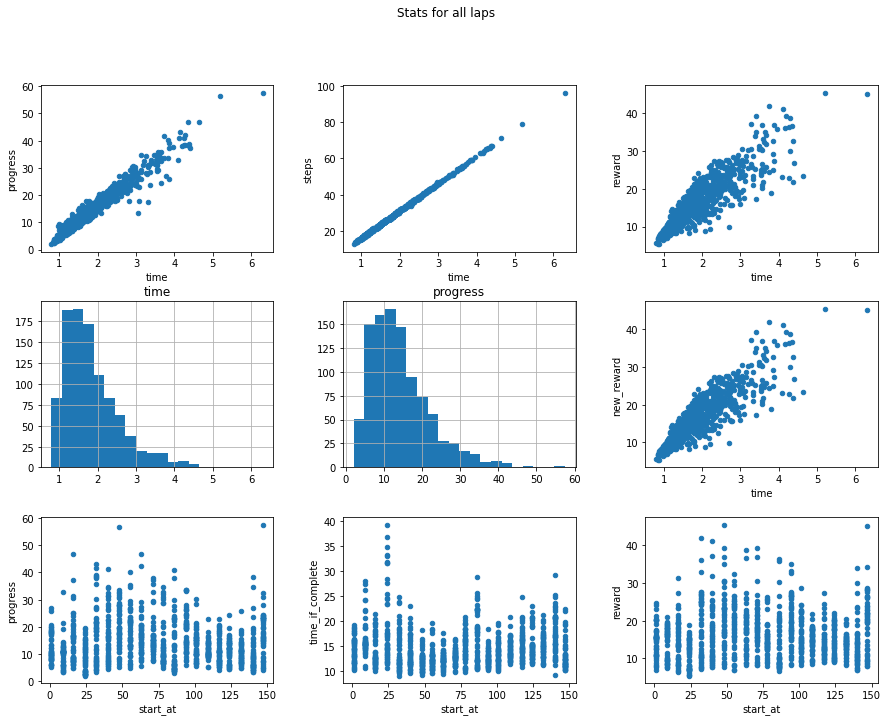

<Figure size 432x288 with 0 Axes>

In [164]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

### Stats for complete laps
The graphs here are same as above, but now I am interested in other type of information:
* does the reward scatter show higher rewards for lower completion times? If I give higher reward for a slower lap it might suggest that I am training the car to go slow
* what does the time histogram look like? With enough samples available the histogram takes a normal distribution graph shape. The lower the mean value, the better the chance to complete a fast lap consistently. The longer the tails, the greater the chance of getting lucky in submissions
* is the car completing laps around the place where the race lap starts? Or does it only succeed if it starts in a place different to the racing one?

In [165]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

No complete laps yet.


### Categories analysis
We're going back to comparing training results based on the training time, but in a different way. Instead of just scattering things in relation to iteration or episode number, this time we're grouping episodes based on a certaing information. For this we use function:
```
analyze_categories(panda, category='quintile', groupcount=5, title=None)
```
The idea is pretty simple - determine a way to cluster the data and provide that as the `category` parameter (alongside the count of groups available). In the default case we take advantage of the aggregated information to which quintile an episode belongs and thus build buckets each containing 20% of episodes which happened around the same time during the training. If your training lasted for five hours, this would show results grouped per each hour.

A side note: if you run the function with `category='start_at'` and `groupcount=20` you will get results based on the waypoint closest to the starting point of an episode. If you need to, you can introduce other types of categories and reuse the function.

The graphs are similar to what we've seen above. I especially like the progress one which shows where the model tends to struggle and whether it's successful laps rate is improving or beginning to decrease. Interestingly, I also had cases where I saw the completion drop on the progress rate only to improve in a later quintile, but with a better time graph.

A second side note: if you run this function for `complete_ones` instead of `simulation_agg`, suddenly the time histogram becomes more interesting as you can see whether completion times improve.

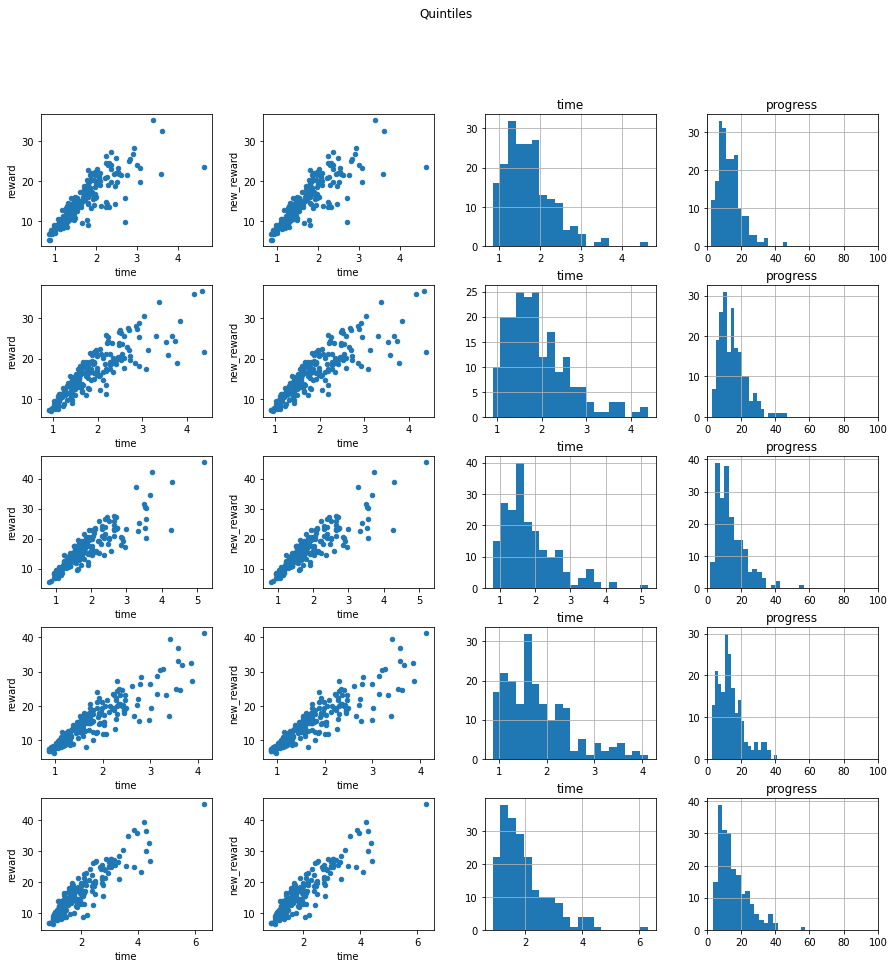

<Figure size 432x288 with 0 Axes>

In [166]:
au.scatter_by_groups(simulation_agg, title='Quintiles')

# Reward Graph 

In [167]:
re_it=simulation_agg.groupby(["iteration"]).mean()

In [168]:
eval_it=bulk.groupby(["iteration"]).mean()

[]

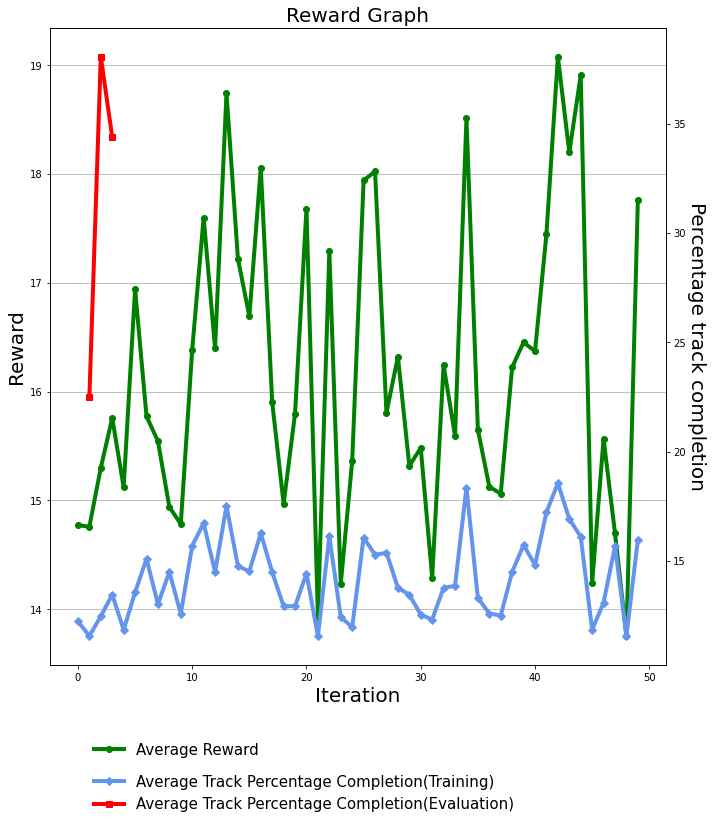

In [169]:
fig,ax=plt.subplots(figsize=(10,10))

ax.plot(re_it["new_reward"],"o-",color="g",linewidth=4,label="Average Reward ")
ax2=ax.twinx()
ax2.plot(re_it["progress"],"D-",color="cornflowerblue",linewidth=4,label="Average Track Percentage Completion(Training) ")
ax.grid(axis="y")
ax2.plot(eval_it["progress"],"s-",color="red",linewidth=4,label="Average Track Percentage Completion(Evaluation) ")
plt.title("Reward Graph",fontsize=20)
ax.set_xlabel("Iteration",fontsize=20)
ax.set_ylabel("Reward",fontsize=20)
ax2.set_ylabel("Percentage track completion",labelpad=20,rotation=270,fontsize=20)
plt.tight_layout()
ax.legend(loc="upper left",bbox_to_anchor=(0.05, -0.1),fontsize=15,frameon=False)
ax2.legend(loc="upper left",bbox_to_anchor=(0.05, -0.15),fontsize=15,frameon=False)
plt.plot()

## Data in tables

While a lot can be seen in graphs that cannot be seen in the raw numbers, the numbers let us get into more detail. Below you will find a couple examples. If your model is behaving the way you would like it to, below tables may provide little added value, but if you struggle to improve your car's performance, they may come handy. In such cases I look for examples where high reward is giving to below-expected episode and when good episodes are given low reward.

You can then take the episode number and scatter it below, and also look at reward given per step - this can in turn draw your attention to some rewarding anomalies and help you detect some unexpected outcomes in your reward function.

There is a number of ways to select the data for display:
* `nlargest`/`nsmallest` lets you display information based on a specific value being highest or lowest
* filtering based on a field value, for instance `df[df['episode']==10]` will display only those steps in `df` which belong to episode 10
* `head()` lets you peek into a dataframe

There isn't a right set of tables to display here and the ones below may not suit your needs. Get to know Pandas more and have fun with them. It's almost as addictive as DeepRacer itself.

The examples have a short comment next to them explaining what they are showing.

In [170]:
# View ten best rewarded episodes in the training
simulation_agg.nlargest(10, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
526,26,526,79.0,48,56.515303,5.198,45.4420,2.936709,45.4420,9.197509,80.406540,3rd,0
859,42,859,96.0,147,57.485281,6.307,45.1824,2.479167,45.1824,10.971504,78.598207,5th,0
404,20,404,57.0,32,41.765042,3.735,42.0618,2.877193,42.0618,8.942886,100.710542,3rd,0
785,39,785,63.0,40,41.103565,4.119,41.1230,3.000000,41.1230,10.021029,100.047284,4th,0
686,34,686,52.0,48,31.686329,3.405,39.3630,2.788462,39.3630,10.745959,124.227075,4th,0
829,41,829,64.0,71,38.117024,4.193,39.3040,2.468750,39.3040,11.000334,103.114031,5th,0
468,23,468,66.0,63,42.223916,4.287,38.7218,2.878788,38.7218,10.153014,91.705848,3rd,0
505,25,505,50.0,40,34.463133,3.267,37.0820,3.200000,37.0820,9.479695,107.599038,3rd,0
689,34,689,55.0,71,35.921032,3.575,36.9016,2.872727,36.9016,9.952387,102.729788,4th,0
886,44,886,59.0,48,25.784541,3.871,36.8240,2.915254,36.8240,15.012871,142.814254,5th,0


In [171]:
# View five fastest complete laps
complete_ones.nsmallest(5, 'time')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete


In [172]:
# View five best rewarded completed laps
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete


In [173]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete


In [174]:
# View five most progressed episodes
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
859,42,859,96.0,147,57.485281,6.307,45.1824,2.479167,45.1824,10.971504,78.598207,5th,0
526,26,526,79.0,48,56.515303,5.198,45.4420,2.936709,45.4420,9.197509,80.406540,3rd,0
122,6,122,71.0,16,46.849802,4.644,23.4828,2.887324,23.4828,9.912529,50.123584,1st,0
268,13,268,66.0,63,46.676960,4.346,36.6628,2.909091,36.6628,9.310803,78.545818,2nd,0
324,16,324,63.0,32,43.001534,4.157,36.0426,2.793651,36.0426,9.667097,83.817011,2nd,0


In [175]:
# View information for a couple first episodes
simulation_agg.head()

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
0,0,0,22.0,1,7.862342,1.375,13.1828,3.045455,13.1828,17.488428,167.670147,1st,0
1,0,1,16.0,9,3.492891,0.976,8.5024,2.937500,8.5024,27.942471,243.420151,1st,0
2,0,2,29.0,16,16.499277,1.852,18.1818,3.206897,18.1818,11.224734,110.197558,1st,0
3,0,3,14.0,24,2.639361,0.840,6.7830,2.857143,6.7830,31.825887,256.994034,1st,0
4,0,4,28.0,32,11.718260,1.778,10.3258,2.892857,10.3258,15.172901,88.117179,1st,0


In [176]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==10]

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,...,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,new_reward
251,10,1.0,8.268401,4.395607,75.067616,0.0,4.0,2,0.000,False,...,0.605905,78,23.118222,54.069,prepare,0.0,0,0,10,0.000
252,10,2.0,8.268254,4.395518,75.098305,30.0,2.0,4,0.800,False,...,0.605387,78,23.118222,54.140,in_progress,0.0,0,0,10,0.800
253,10,3.0,8.270785,4.400303,74.745404,0.0,4.0,2,1.000,False,...,0.627996,78,23.118222,54.157,in_progress,0.0,0,0,10,1.000
254,10,4.0,8.281260,4.424790,73.899260,30.0,2.0,4,0.800,False,...,0.741320,79,23.118222,54.273,in_progress,0.0,0,0,10,0.800
255,10,5.0,8.292329,4.478512,74.759233,30.0,2.0,4,0.800,False,...,0.977232,79,23.118222,54.325,in_progress,0.0,0,0,10,0.800
256,10,6.0,8.293413,4.490581,75.277483,0.0,4.0,2,1.000,False,...,1.029418,79,23.118222,54.397,in_progress,0.0,0,0,10,1.000
257,10,7.0,8.300222,4.574717,78.474765,15.0,3.0,3,1.000,False,...,1.392613,80,23.118222,54.481,in_progress,0.0,0,0,10,1.000
258,10,8.0,8.304585,4.681965,82.142767,-15.0,3.0,1,1.000,False,...,1.855244,80,23.118222,54.514,in_progress,0.0,0,0,10,1.000
259,10,9.0,8.304618,4.783730,85.011162,-30.0,2.0,0,0.800,False,...,2.298552,81,23.118222,54.578,in_progress,0.0,0,0,10,0.800
260,10,10.0,8.315664,4.919401,85.066536,0.0,4.0,2,1.000,False,...,2.887352,82,23.118222,54.654,in_progress,0.0,0,0,10,1.000


## Analyze the reward distribution for your reward function

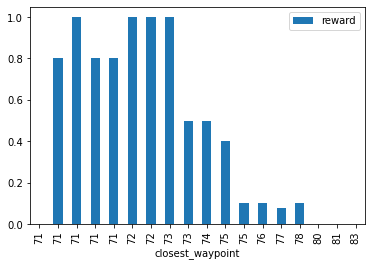

In [177]:
# This shows a histogram of actions per closest waypoint for episode 889.
# Will let you spot potentially problematic places in reward granting.
# In this example reward function is clearly `return 1`. It may be worrying
# if your reward function has some logic in it.
# If you have a final step reward that makes the rest of this histogram
# unreadable, you can filter the last step out by using
# `episode[:-1].plot.bar` instead of `episode.plot.bar`
episode = df[df['episode']==9]

if episode.empty:
    print("You probably don't have episode with this number, try a lower one.")
else:
    episode.plot.bar(x='closest_waypoint', y='reward')

### Path taken for top reward iterations

NOTE: at some point in the past in a single episode the car could go around multiple laps, the episode was terminated when car completed 1000 steps. Currently one episode has at most one lap. This explains why you can see multiple laps in an episode plotted below.

Being able to plot the car's route in an episode can help you detect certain patterns in its behaviours and either promote them more or train away from them. While being able to watch the car go in the training gives some information, being able to reproduce it after the training is much more practical.

Graphs below give you a chance to look deeper into your car's behaviour on track.

We start with plot_selected_laps. The general idea of this block is as follows:
* Select laps(episodes) that have the properties that you care about, for instance, fastest, most progressed, failing in a certain section of the track or not failing in there,
* Provide the list of them in a dataframe into the plot_selected_laps, together with the whole training dataframe and the track info,
* You've got the laps to analyse.

In [178]:
#episodes_to_plot

In [179]:
episodes_to_plot = simulation_agg.nlargest(3,'progress')

df1 = episode
#df1.drop(['stream'], axis =1)

In [180]:
simulation_agg

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
0,0,0,22.0,1,7.862342,1.375,13.1828,3.045455,13.1828,17.488428,167.670147,1st,0
1,0,1,16.0,9,3.492891,0.976,8.5024,2.937500,8.5024,27.942471,243.420151,1st,0
2,0,2,29.0,16,16.499277,1.852,18.1818,3.206897,18.1818,11.224734,110.197558,1st,0
3,0,3,14.0,24,2.639361,0.840,6.7830,2.857143,6.7830,31.825887,256.994034,1st,0
4,0,4,28.0,32,11.718260,1.778,10.3258,2.892857,10.3258,15.172901,88.117179,1st,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,49,995,19.0,117,6.818232,1.172,11.0818,2.736842,11.0818,17.189207,162.531870,5th,0
996,49,996,18.0,124,5.345966,1.100,10.4826,2.500000,10.4826,20.576264,196.084314,5th,0
997,49,997,19.0,132,7.118533,1.206,12.1830,2.947368,12.1830,16.941692,171.144804,5th,0
998,49,998,22.0,140,9.028335,1.413,12.5028,3.090909,12.5028,15.650726,138.484005,5th,0


### Plot a heatmap of rewards for current training. 
The brighter the colour, the higher the reward granted in given coordinates.
If instead of a similar view as in the example below you get a dark image with hardly any 
dots, it might be that your rewards are highly disproportionate and possibly sparse.

Disproportion means you may have one reward of 10.000 and the rest in range 0.01-1.
In such cases the vast majority of dots will simply be very dark and the only bright dot
might be in a place difficult to spot. I recommend you go back to the tables and show highest
and average rewards per step to confirm if this is the case. Such disproportions may
not affect your traning very negatively, but they will make the data less readable in this notebook.

Sparse data means that the car gets a high reward for the best behaviour and very low reward
for anything else, and worse even, reward is pretty much discrete (return 10 for narrow perfect,
else return 0.1). The car relies on reward varying between behaviours to find gradients that can
lead to improvement. If that is missing, the model will struggle to improve.

In [181]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column

#PlottingUtils.plot_track(df, track)

### Plot a particular iteration
This is same as the heatmap above, but just for a single iteration.

In [182]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column
iteration_id = 3

pu.plot_track(df[df['iteration'] == iteration_id], track)

NameError: name 'pu' is not defined

In [183]:
dfx=df[df.iteration == 0]

In [184]:
dfx

,episode,steps,x,y,heading,steering_angle,speed,action,reward,done,...,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,iteration,worker,unique_episode,new_reward
0,0,1.0,0.322574,2.691129,-83.997356,15.0,3.0,3,0.0000,False,...,0.606669,1,23.118222,36.553,prepare,0.0,0,0,0,0.0000
1,0,2.0,0.322497,2.691373,-84.006075,-15.0,3.0,1,1.0000,False,...,0.605583,1,23.118222,36.605,in_progress,0.0,0,0,0,1.0000
2,0,3.0,0.325440,2.684613,-83.473136,-30.0,2.0,0,0.8000,False,...,0.635991,1,23.118222,36.659,in_progress,0.0,0,0,0,0.8000
3,0,4.0,0.325739,2.667871,-83.839073,0.0,4.0,2,1.0000,False,...,0.708236,1,23.118222,36.707,in_progress,0.0,0,0,0,1.0000
4,0,5.0,0.326850,2.616956,-84.861197,0.0,4.0,2,1.0000,False,...,0.926952,1,23.118222,36.781,in_progress,0.0,0,0,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,19,16.0,-0.093981,2.638227,-116.008334,30.0,2.0,4,0.0800,False,...,5.646094,1,23.118222,71.993,in_progress,0.0,0,0,19,0.0800
512,19,17.0,-0.153242,2.507724,-115.213886,15.0,3.0,3,0.1000,False,...,6.101862,2,23.118222,72.073,in_progress,0.0,0,0,19,0.1000
513,19,18.0,-0.236827,2.272658,-110.991723,-30.0,2.0,0,0.0008,False,...,6.938698,3,23.118222,72.133,in_progress,0.0,0,0,19,0.0008
514,19,19.0,-0.256880,2.206759,-109.653993,-30.0,2.0,0,0.0008,False,...,7.089007,3,23.118222,72.201,in_progress,0.0,0,0,19,0.0008


In [185]:
df = dfx

In [186]:
dataf=pd.DataFrame()
dataf["x"]=df["x"]
dataf["y"]=df["y"]

In [187]:
dataf= dataf[50]

KeyError: 50

In [196]:
dfn = []
dfh = []
flag = 0
i=0
while i< 500:#len(df)-2:
#     diffx = dataf.x[i] - dataf.x[i-1]
#     diffy =  dataf.y[i] - dataf.y[i-1]
#     d = diffx**2 + diffy**2
#     diffx1 =  dataf.x[i-1] - dataf.x[i-2]
#     diffy1 = dataf.y[i-1] - dataf.y[i-2]
#     d1 = diffx1**2 + diffy1**2
    j=i+1
    d = df.speed[i]
    d1 = df.speed[j]
    #dfn.append([df.x[j+1],df.y[j+1],df.speed[j+1]])
    while d == d1:
        #dfn.append([[[df.x[i]],[df.y[i]],[df.speed[i]]]])
        j+=1
        d1 = df.speed[j]
    dfn.append([df.x[j],df.y[j],df.speed[j]])
    
    i=j

In [189]:
len(dfn)

612

In [205]:
dfn

[[0.3254397787547759, 2.684613494479186, 2.0],
 [0.3257391207068424, 2.6678711402100954, 4.0],
 [0.32739412373406285, 2.5980339454061707, 3.0],
 [0.33385120067367724, 2.521548085307434, 4.0],
 [0.3379875290777882, 2.4588181133609863, 3.0],
 [0.4064866017889433, 1.983561002351568, 2.0],
 [0.4329604762901189, 1.837682307996307, 4.0],
 [0.4736759452449616, 1.6694854434973194, 2.0],
 [0.543773655048394, 1.370867824257351, 4.0],
 [0.5734782268980471, 1.2186451043091142, 3.0],
 [0.6005258588601305, 1.0807800542442247, 4.0],
 [0.6302157763541342, 0.9400875254776888, 2.0],
 [0.6862425890810637, 0.716546432778093, 4.0],
 [0.7307997646302293, 0.5789589325353559, 2.0],
 [0.7837130671634811, 0.4234354142688305, 3.0],
 [0.6603887174195313, 1.5941015161204526, 2.0],
 [0.6603711201634437, 1.5940953454084914, 3.0],
 [0.6668020139022666, 1.5761302291285992, 4.0],
 [0.7036225225963432, 1.5006478322643308, 3.0],
 [0.7296196882942518, 1.4397964185124823, 2.0],
 [0.7600553355440449, 1.374080612121677, 3.0]

In [206]:
dfp = pd.DataFrame(dfn, columns =['x', 'y', 'speed']) 
#dfh = pd.DataFrame(dfn, columns =['x', 'y', 'speed']) 
dfp

,x,y,speed
0,0.325440,2.684613,2.0
1,0.325739,2.667871,4.0
2,0.327394,2.598034,3.0
3,0.333851,2.521548,4.0
4,0.337988,2.458818,3.0
5,0.406487,1.983561,2.0
6,0.432960,1.837682,4.0
7,0.473676,1.669485,2.0
8,0.543774,1.370868,4.0
9,0.573478,1.218645,3.0


In [231]:
# for i in range(0,len(dfp)-1,2):
#         plt.arrow(dfp["x"][i],dfp["y"][i],(dfp["x"][i+1]-dfp["x"][i]),(dfp["y"][i+1]-dfp["y"][i]),width=0.06,color="#cb4579",label="15° or -15°")
                           

In [38]:
len(dataf)

28922

In [39]:
data=df[df["iteration"]==0]

In [40]:
class TrackPlotter:
    """Utility to help when trying to plot a track
    """
    @staticmethod
    def plot_track(to_plot, show=True):
        """Plot waypoints for the track
        Arguments:
        waypoints - waypoints to be plotted or the Track object
        show - whether to plot straight away - you may chose to add more to plot
               default value: True
        """
        import matplotlib.pyplot as plt

        if isinstance(to_plot, Track):
            to_plot = to_plot.waypoints

        for point in to_plot:
            plt.scatter(point[0], point[1], c="blue")
            plt.scatter(point[2], point[3], c="black")
            plt.scatter(point[4], point[5], c="blue")

        if show:
            plt.show()

In [229]:
from datetime import datetime
from decimal import Decimal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from shapely.geometry.polygon import LineString

class Track:
    """Track object represents a track.
    I know, right?
    Fields:
    name - name of the track loaded
    waypoints - input list as received by constructor
    center_line - waypoints along the center of the track with coordinates in meters
    inner_border - waypoints along the inner border of the track with coordinates in meters
    outer_border - waypoints along the outer border of the track with coordinates in meters
    road_poly - a polygon representing the track
    """

    def __init__(self, name, waypoints):
        """Create Track object
        Arguments:
        name - name of the track
        waypoints - values from a npy file for the track
        """
        self.name = name
        self.waypoints = waypoints
        self.center_line = waypoints[:, 0:2]
        self.inner_border = waypoints[:, 2:4]
        self.outer_border = waypoints[:, 4:6]

        l_inner_border = LineString(waypoints[:, 2:4])
        l_outer_border = LineString(waypoints[:, 4:6])
        self.road_poly = Polygon(
            np.vstack((l_outer_border, np.flipud(l_inner_border))))

    def size(self):
        """Track bounding box size tuple
        """
        return (
            np.max(self.outer_border[:, 0]) - np.min(self.outer_border[:, 0]),
            np.max(self.outer_border[:, 1]) - np.min(self.outer_border[:, 1])
        )

    def ratio(self):
        """Track size ratio
        """
        s = self.size()
        return s[1] / s[0]



class SimulationLogsIO:
    """ Utilities for loading the logs
    """

    @staticmethod
    def load_single_file(fname, data=None):
        """Loads a single log file and remembers only the SIM_TRACE_LOG lines
        Arguments:
        fname - path to the file
        data - list to populate with SIM_TRACE_LOG lines. Default: None
        Returns:
        List of loaded log lines. If data is not None, it is the reference returned
        and the list referenced has new log lines appended
        """
        if data is None:
            data = []

        with open(fname, 'r') as f:
            for line in f.readlines():
                if "SIM_TRACE_LOG" in line:
                    parts = line.split("SIM_TRACE_LOG:")[1].split('\t')[0].split(",")
                    data.append(",".join(parts))

        return data

    @staticmethod
    def load_data(fname):
        """Load all log files for a given simulation
        Looks for all files for a given simulation and loads them. Takes the local training
        into account where in some cases the logs are split when they reach a certain size,
        and given a suffix .1, .2 etc.
        Arguments:
        fname - path to the file
        Returns:
        List of loaded log lines
        """
        from os.path import isfile
        data = []

        i = 1

        while isfile('%s.%s' % (fname, i)):
            SimulationLogsIO.load_single_file('%s.%s' % (fname, i), data)
            i += 1

        SimulationLogsIO.load_single_file(fname, data)

        if i > 1:
            print("Loaded %s log files (logs rolled over)" % i)

        return data

    @staticmethod
    def convert_to_pandas(data, episodes_per_iteration=20):
        """Load the log data to pandas dataframe
        Reads the loaded log files and parses them according to this format of print:
        stdout_ = 'SIM_TRACE_LOG:%d,%d,%.4f,%.4f,%.4f,%.2f,%.2f,%d,%.4f,%s,%s,%.4f,%d,%.2f,%s\n' % (
                self.episodes, self.steps, model_location[0], model_location[1], model_heading,
                self.steering_angle,
                self.speed,
                self.action_taken,
                self.reward,
                self.done,
                all_wheels_on_track,
                current_progress,
                closest_waypoint_index,
                self.track_length,
                time.time())
            print(stdout_)
        Currently only supports 2019 logs but is forwards compatible.
        Arguments:
        data - list of log lines to parse
        episodes_per_iteration - value of the hyperparameter for a given training
        Returns:
        A pandas dataframe with loaded data
        """

        df_list = list()

        # ignore the first two dummy values that coach throws at the start.
        for d in data[2:]:
            parts = d.rstrip().split(",")
            # TODO: this is a workaround and should be removed when logs are fixed
            parts_workaround = 0
            if len(parts) > 17:
                parts_workaround = 1
            episode = int(parts[0])
            steps = int(parts[1])
            x = float(parts[2])
            y = float(parts[3])
            yaw = float(parts[4])
            steering_angle = float(parts[5])
            speed = float(parts[6])
            try:
                action = int(parts[7])
            except ValueError as e:
                action = -1
            reward = float(parts[8+parts_workaround])
            done = 0 if 'False' in parts[9+parts_workaround] else 1
            all_wheels_on_track = parts[10+parts_workaround]
            progress = float(parts[11+parts_workaround])
            closest_waypoint = int(parts[12+parts_workaround])
            track_len = float(parts[13+parts_workaround])
            tstamp = Decimal(parts[14+parts_workaround])
            episode_status = parts[15+parts_workaround]
            if len(parts) > 16+parts_workaround:
                pause_duration = float(parts[16+parts_workaround])
            else:
                pause_duration = 0.0

            iteration = int(episode / episodes_per_iteration) + 1
            df_list.append((iteration, episode, steps, x, y, yaw, steering_angle, speed,
                            action, reward, done, all_wheels_on_track, progress,
                            closest_waypoint, track_len, tstamp, episode_status, pause_duration))

        header = ['iteration', 'episode', 'steps', 'x', 'y', 'yaw', 'steering_angle',
                  'speed', 'action', 'reward', 'done', 'on_track', 'progress',
                  'closest_waypoint', 'track_len', 'tstamp', 'episode_status', 'pause_duration']

        df = pd.DataFrame(df_list, columns=header)
        return df

    @staticmethod
    def load_a_list_of_logs(logs):
        """Loads multiple logs from the list of tuples
        For each file being loaded additional info about the log stream is attached.
        This way one can load multiple simulations for a given period and compare the outcomes.
        This is particularly helpful when comparing multiple evaluations.
        Arguments:
        logs - a list of tuples describing the logs, compatible with the output of
            CloudWatchLogs.download_all_logs
        Returns:
        A pandas dataframe containing all loaded logs data
        """
        full_dataframe = None
        for log in logs:
            eval_data = SimulationLogsIO.load_data(log[0])
            dataframe = SimulationLogsIO.convert_to_pandas(eval_data)
            dataframe['stream'] = log[1]
            if full_dataframe is not None:
                full_dataframe = full_dataframe.append(dataframe)
            else:
                full_dataframe = dataframe

        return full_dataframe.sort_values(
            ['stream', 'episode', 'steps']).reset_index()

    @staticmethod
    def load_pandas(fname, episodes_per_iteration=20):
        """Load from a file directly to pandas dataframe
        Arguments:
        fname - path to the file
        episodes_per_iteration - value of the hyperparameter for a given training
        Returns:
        A pandas dataframe with loaded data
        """
        return SimulationLogsIO.convert_to_pandas(
            SimulationLogsIO.load_data(fname),
            episodes_per_iteration
        )

    @staticmethod
    def normalize_rewards(df):
        """Normalize the rewards to a 0-1 scale
        Arguments:
        df - pandas dataframe with the log data
        """
        from sklearn.preprocessing import MinMaxScaler

        min_max_scaler = MinMaxScaler()
        scaled_vals = min_max_scaler.fit_transform(
            df['reward'].values.reshape(df['reward'].values.shape[0], 1))
        df['reward'] = pd.DataFrame(scaled_vals.squeeze())


class AnalysisUtils:
    """Set of utilities to verify how the training is doing.
    The general purpose is to extract information from the dataframe to visualize it
    in form which allows drawing conclusions from them
    """
    @staticmethod
    def simulation_agg(panda, firstgroup='iteration', add_tstamp=False, is_eval=False):
        """Groups all log data by episodes and other information and returns
        a pandas dataframe with aggregated information
        The aggregated data includes:
        * steps - amount of steps per episode,
        * start_at - starting waypoint
        * progress - how much of the track has been covered
        * speed - average speed decision
        * time - how much time elapsed from first to last step
        * reward - how much reward has been aggregated in the iteration
        * time_if_complete - scales time from given progress value to 100% to give
            an idea of what time the car would have if the lap would be completed
        Also if data is for training:
        * new_reward - how much reward would have been aggregated if another
            reward would be used (based on the NewRewardUtils usage)
        * reward_if_complete - scales reward from given progress value to 100% to give
            an idea of what time the car would have if the lap would be completed
        * quintile - which training quintile the episode happened in
            (first 20% of episodes are in 1st, second 20% in 2nd etc.)
        Also if timestamp is requested:
        * tstamp - when given episode ended
        Arguments:
        panda - panda dataframe with simulation data
        firstgroup - first group to group by, by default iteration,
        for multiple log files loaded stream would be preferred
        add_tstamp - whether to add a timestamp, by default False
        is_eval - is data for evaluation (training if False), default: False
        Returns:
        Aggregated dataframe
        """
        grouped = panda.groupby([firstgroup, 'episode'])

        by_steps = grouped['steps'].agg(np.max).reset_index()
        by_start = grouped.first()['closest_waypoint'].reset_index() \
            .rename(index=str, columns={"closest_waypoint": "start_at"})
        by_progress = grouped['progress'].agg(np.max).reset_index()
        by_speed = grouped['speed'].agg(np.mean).reset_index()
        by_time = grouped['tstamp'].agg(np.ptp).reset_index() \
            .rename(index=str, columns={"tstamp": "time"})
        by_time['time'] = by_time['time'].astype(float)

        result = by_steps \
            .merge(by_start) \
            .merge(by_progress, on=[firstgroup, 'episode']) \
            .merge(by_time, on=[firstgroup, 'episode'])

        if not is_eval:
            if 'new_reward' not in panda.columns:
                print('new reward not found, using reward as its values')
                panda['new_reward'] = panda['reward']
            by_new_reward = grouped['new_reward'].agg(np.sum).reset_index()
            result = result.merge(by_new_reward, on=[firstgroup, 'episode'])

        result = result.merge(by_speed, on=[firstgroup, 'episode'])

        if not is_eval:
            by_reward = grouped['reward'].agg(np.sum).reset_index()
            result = result.merge(by_reward, on=[firstgroup, 'episode'])

        result['time_if_complete'] = result['time'] * 100 / result['progress']

        if not is_eval:
            result['reward_if_complete'] = result['reward'] * 100 / result['progress']
            result['quintile'] = pd.cut(result['episode'], 5, labels=[
                                        '1st', '2nd', '3rd', '4th', '5th'])

        if add_tstamp:
            by_tstamp = grouped['tstamp'].agg(np.max).astype(float).reset_index()
            by_tstamp['tstamp'] = pd.to_datetime(by_tstamp['tstamp'], unit='s')
            result = result.merge(by_tstamp, on=[firstgroup, 'episode'])

        return result

    @staticmethod
    def scatter_aggregates(aggregate_df, title=None, is_eval=False):
        """Scatter aggregated data in a set of charts.
        If the data is for evaluation, fewer graphs are shown which makes
        them more readable.
        This set of charts is focused on dependencies other than on iteration/episode.
        Arguments:
        aggregate_df - aggregated data
        title - what title to give to the charts (None by default)
        is_eval - is it evaluation data (training if False), by default False
        """
        fig, axes = plt.subplots(nrows=2 if is_eval else 3,
                                 ncols=2 if is_eval else 3, figsize=[15, 11])
        if title:
            fig.suptitle(title)
        if not is_eval:
            aggregate_df.plot.scatter('time', 'reward', ax=axes[0, 2])
            aggregate_df.plot.scatter('time', 'new_reward', ax=axes[1, 2])
            aggregate_df.plot.scatter('start_at', 'reward', ax=axes[2, 2])
            aggregate_df.plot.scatter('start_at', 'progress', ax=axes[2, 0])
            aggregate_df.plot.scatter('start_at', 'time_if_complete', ax=axes[2, 1])
        aggregate_df.plot.scatter('time', 'progress', ax=axes[0, 0])
        aggregate_df.hist(column=['time'], bins=20, ax=axes[1, 0])
        aggregate_df.plot.scatter('time', 'steps', ax=axes[0, 1])
        aggregate_df.hist(column=['progress'], bins=20, ax=axes[1, 1])

        plt.show()
        plt.clf()

    @staticmethod
    def scatter_by_groups(aggregate_df, group_category='quintile', title=None):
        """Visualise aggregated training data grouping them by a given category.
        Takes the aggregated dataframe and groups it by category.
        By default quintile is being used which means all episodes are divided into
        five buckets by time. This lets you observe how the training progressed
        with time
        Arguments:
        aggregate_df - aggregated dataframe
        group_category - what to group the data by, default: quintile
        title - what title to put over the charts, default: None
        """
        grouped = aggregate_df.groupby(group_category)
        groupcount = len(grouped.groups.keys())

        fig, axes = plt.subplots(nrows=groupcount, ncols=4, figsize=[15, 15])

        if title:
            fig.suptitle(title)

        row = 0
        for _, group in grouped:
            group.plot.scatter('time', 'reward', ax=axes[row, 0])
            group.plot.scatter('time', 'new_reward', ax=axes[row, 1])
            group.hist(column=['time'], bins=20, ax=axes[row, 2])
            axes[row, 3].set(xlim=(0, 100))
            group.hist(column=['progress'], bins=20, ax=axes[row, 3])
            row += 1

        plt.show()
        plt.clf()

    @staticmethod
    def analyze_training_progress(aggregates, title=None):
        """Analyze training progress based on iterations
        Most of the charts have iteration as the x axis which shows how rewards,
        times, progress and others have changed in time iteration by iteration.
        The graphs present:
        * mean reward with standard deviation
        * total reward
        * mean time with standard deviation
        * mean time for completed laps
        * mean progress with standard deviation
        * completion rate (ratio of complete laps to all episodes in iteration, 0-1)
        Arguments:
        aggregates - aggregated dataframe to analyze
        title - what title to put over the charts, default: None
        """
        aggregates['complete'] = np.where(aggregates['progress'] == 100, 1, 0)

        grouped = aggregates.groupby('iteration')

        reward_per_iteration = grouped['reward'].agg([np.mean, np.std]).reset_index()
        time_per_iteration = grouped['time'].agg([np.mean, np.std]).reset_index()
        progress_per_iteration = grouped['progress'].agg([np.mean, np.std]).reset_index()

        complete_laps = aggregates[aggregates['progress'] == 100.0]
        complete_grouped = complete_laps.groupby('iteration')

        complete_times = complete_grouped['time'].agg([np.mean, np.min, np.max]).reset_index()

        total_completion_rate = complete_laps.shape[0] / aggregates.shape[0]

        complete_per_iteration = grouped['complete'].agg([np.mean]).reset_index()

        print('Number of episodes = ', np.max(aggregates['episode']))
        print('Number of iterations = ', np.max(aggregates['iteration']))

        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=[15, 15])

        if title:
            fig.suptitle(title)

        AnalysisUtils.plot(axes[0, 0], reward_per_iteration, 'iteration', 'Iteration',
                           'mean', 'Mean reward', 'Rewards per Iteration')
        AnalysisUtils.plot(axes[1, 0], reward_per_iteration, 'iteration',
                           'Iteration', 'std', 'Std dev of reward', 'Dev of reward')
        AnalysisUtils.plot(axes[2, 0], aggregates, 'episode', 'Episode', 'reward', 'Total reward')

        AnalysisUtils.plot(axes[0, 1], time_per_iteration, 'iteration',
                           'Iteration', 'mean', 'Mean time', 'Times per Iteration')
        AnalysisUtils.plot(axes[1, 1], time_per_iteration, 'iteration',
                           'Iteration', 'std', 'Std dev of time', 'Dev of time')
        if complete_times.shape[0] > 0:
            AnalysisUtils.plot(axes[2, 1], complete_times, 'iteration', 'Iteration',
                               'mean', 'Time', 'Mean completed laps time')

        AnalysisUtils.plot(axes[0, 2], progress_per_iteration, 'iteration', 'Iteration', 'mean',
                           'Mean progress', 'Progress per Iteration')
        AnalysisUtils.plot(axes[1, 2], progress_per_iteration, 'iteration',
                           'Iteration', 'std', 'Std dev of progress', 'Dev of progress')
        AnalysisUtils.plot(axes[2, 2], complete_per_iteration, 'iteration', 'Iteration', 'mean',
                           'Completion rate', 'Completion rate (avg: %s)' % total_completion_rate)

        plt.show()
        plt.clf()

    @staticmethod
    def plot(ax, df, xval, xlabel, yval, ylabel, title=None):
        """plot the data and put in the right place on charts image
        Arguments:
        ax - plot axes
        df - dataframe to extract data from
        xval - which data to extract for x axis
        xlabel - what label to give the x axis
        yval - which data to extract for y axis
        ylabel - what label to give the y axis
        title - what title to put over the chart, default: None
        """
        df.plot.scatter(xval, yval, ax=ax, s=5, alpha=0.7)
        if title:
            ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.set_xlabel(xlabel)

        plt.grid(True)

        


class PlottingUtils:
    """Utilities to visualise track and the episodes
    """
    @staticmethod
    def print_border(ax, track: Track, color='lightgrey'):
        """Print track borders on the chart
        Arguments:
        ax - axes to plot borders on
        track - the track info to plot
        color - what color to plot the border in, default: lightgrey
        """
        line = LineString(track.center_line)
        PlottingUtils._plot_coords(ax, line)
        PlottingUtils._plot_line(ax, line, color)

        line = LineString(track.inner_border)
        PlottingUtils._plot_coords(ax, line)
        PlottingUtils._plot_line(ax, line, color)

        line = LineString(track.outer_border)
        PlottingUtils._plot_coords(ax, line)
        PlottingUtils._plot_line(ax, line, color)

    @staticmethod
    def plot_selected_laps(sorted_idx, df, track: Track, section_to_plot="episode"):
        """Plot n laps in the training, referenced by episode ids
        Arguments:
        sorted_idx - a datagram with ids to be plotted or a list of ids
        df - a datagram with all data
        track - track info for plotting
        secton_to_plot - what section of data to plot - episode/iteration
        """

        ids = sorted_idx

        if type(sorted_idx) is not list:
            ids = sorted_idx[section_to_plot].unique().tolist()

        n_laps = len(ids)

        fig = plt.figure(n_laps, figsize=(12, n_laps * 10))
        for i in range(n_laps):
            idx = ids[i]

            data_to_plot = df[df[section_to_plot] == idx]

            ax = fig.add_subplot(n_laps, 1, i + 1)

            ax.axis('equal')

            PlottingUtils.print_border(ax, track, color='cyan')

            data_to_plot.plot.scatter('x', 'y', ax=ax, s=10, c='blue')

        plt.show()
        plt.clf()

        # return fig

    @staticmethod
    def plot_evaluations(evaluations, track: Track, graphed_value='speed'):
        """Plot graphs for evaluations
        """
        from math import ceil

        streams = evaluations.sort_values(
            'tstamp', ascending=False).groupby('stream', sort=False)

        for _, stream in streams:
            episodes = stream.groupby('episode')
            ep_count = len(episodes)

            rows = ceil(ep_count / 3)
            columns = min(ep_count, 3)

            fig, axes = plt.subplots(rows, columns, figsize=(7*columns, 5*rows))
            fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=7.0)

            for id, episode in episodes:
                if rows == 1:
                    ax = axes[id % 3]
                elif columns == 1:
                    ax = axes[int(id/3)]
                else:
                    ax = axes[int(id / 3), id % 3]

                PlottingUtils.plot_grid_world(
                    episode, track, graphed_value, ax=ax)

            plt.show()
            plt.clf()

    @staticmethod
    def plot_grid_world(
        episode_df,
        track: Track,
        graphed_value='speed',
        min_progress=None,
        ax=None,
        points_gap=1,
        heading_arrow=False
    ):
        """Plot a scaled version of lap, along with speed taken a each position
        """

        episode_df.loc[:, 'distance_diff'] = ((episode_df['x'].shift(1) - episode_df['x']) ** 2 + (
            episode_df['y'].shift(1) - episode_df['y']) ** 2) ** 0.5

        distance = np.nansum(episode_df['distance_diff'])
        lap_time = np.ptp(episode_df['tstamp'].astype(float))
        velocity = distance / lap_time
        average_speed = np.nanmean(episode_df['speed'])
        progress = np.nanmax(episode_df['progress'])

        if not min_progress or progress > min_progress:

            distance_lap_time = 'Distance, progress, lap time = %.2f m, %.2f %%, %.2f s' % (
                distance, progress, lap_time
            )
            speed_velocity = 'Average speed, velocity = %.2f (Gazebo), %.2f m/s' % (
                average_speed, velocity
            )

            fig = None
            if ax is None:
                fig = plt.figure(figsize=(15, 15))
                ax1 = fig.add_subplot(2, 2, 3)
                ax2=fig.add_subplot(2,2,4)
                

            ax1.set_facecolor('#03c389')
            ax2.set_facecolor('#03c389')
            
            line = LineString(track.inner_border)
            PlottingUtils._plot_coords(ax1, line)
            PlottingUtils._plot_line(ax1, line)
            PlottingUtils._plot_coords(ax2, line)
            PlottingUtils._plot_line(ax2, line)

            line = LineString(track.outer_border)
            PlottingUtils._plot_coords(ax1, line)
            PlottingUtils._plot_line(ax1, line)
            PlottingUtils._plot_coords(ax2, line)
            PlottingUtils._plot_line(ax2, line)

            episode_df.plot.scatter('x', 'y', ax=ax1, s=2) 
 #                                   c=graphed_value,cmap=plt.get_cmap('plasma'))
            episode_df.plot.scatter('x', 'y', ax=ax2, s=10)
            #episode_df.plot.scatter('x', 'y', ax=ax2, s=10, c=graphed_value,
             #                       cmap=plt.get_cmap('plasma'))

            subtitle = '%s%s\n%s\n%s' % (
                ('Stream: %s, ' % episode_df['stream'].iloc[0]
                 ) if 'stream' in episode_df.columns else '',
                datetime.fromtimestamp(episode_df['tstamp'].iloc[0]),
                distance_lap_time,
                speed_velocity)
            ax1.set_title(subtitle)

            if fig:
                if heading_arrow==True:
                    for i in range(0,len(episode_df)-1,points_gap):
                       # plt.arrow(episode_df["x"][i],episode_df["y"][i],1,1,width=0.006)
                        
                        if episode_df["steering_angle"][i]==((15.0) or (-15.0)): 
                           # ax2.scatter(episode_df[])
                            ax2.arrow(episode_df["x"][i],episode_df["y"][i],(episode_df["x"][i+1]-episode_df["x"][i]),(episode_df["y"][i+1]-episode_df["y"][i]),width=0.06,color="#cb4579",label="15° or -15°")
                            ax1.arrow(episode_df["x"][i],episode_df["y"][i],(episode_df["x"][i+1]-episode_df["x"][i]),(episode_df["y"][i+1]-episode_df["y"][i]),width=0.06)
                        elif episode_df["steering_angle"][i]==(0.0):
                            ax2.arrow(episode_df["x"][i],episode_df["y"][i],(episode_df["x"][i+1]-episode_df["x"][i]),(episode_df["y"][i+1]-episode_df["y"][i]),width=0.06,color="#f1f524",label="0°")
                            ax1.arrow(episode_df["x"][i],episode_df["y"][i],(episode_df["x"][i+1]-episode_df["x"][i]),(episode_df["y"][i+1]-episode_df["y"][i]),width=0.06)
                        elif episode_df["steering_angle"][i]==((30.0) or (-30.0)):
                            ax2.arrow(episode_df["x"][i],episode_df["y"][i],(episode_df["x"][i+1]-episode_df["x"][i]),(episode_df["y"][i+1]-episode_df["y"][i]),width=0.06,color="#17078a",label="30° or -30°")
                            ax1.arrow(episode_df["x"][i],episode_df["y"][i],(episode_df["x"][i+1]-episode_df["x"][i]),(episode_df["y"][i+1]-episode_df["y"][i]),width=0.06)
                  
                    handles, labels = ax2.get_legend_handles_labels()
                    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
                    ax2.legend(*zip(*unique))
                    #fig = px.scatter(episode_df, x="x", y="y",
                # color="steering_angle")
                    #plrr=px.scatter(1,1)
                    #plrr.show()
                    ax1.set_title("Heading Direction")
                    ax2.set_title("Steering angle at particular Direction")
                    fig.show
                    plt.show()
                    plt.clf()
        
    @staticmethod
    def plot_track(df, track: Track, value_field="reward", margin=1, cmap="hot"):
        """Plot track with dots presenting the rewards for steps
        """
        if df.empty:
            print("The dataframe is empty, check if you have selected an existing subset")
            return

        track_size = (np.asarray(track.size()) + 2*margin).astype(int) * 100
        track_img = np.zeros(track_size).transpose()

        x_coord = 0
        y_coord = 1

        # compensation moves car's coordinates in logs to start at 0 in each dimention
        x_compensation = track.outer_border[:, 0].min()
        y_compensation = track.outer_border[:, 1].min()

        for _, row in df.iterrows():
            x = int((row["x"] - x_compensation + margin) * 100)
            y = int((row["y"] - y_compensation + margin) * 100)

            # clip values that are off track
            if y >= track_size[y_coord]:
                y = track_size[y_coord] - 1

            if x >= track_size[x_coord]:
                x = track_size[x_coord] - 1

            track_img[y, x] = row[value_field]

        fig = plt.figure(1, figsize=(12, 16))
       # fig = plt.figure(2, figsize=(12, 64))
        ax1 = fig.add_subplot(111)
        ax2 =fig.add_subplot(222)

        shifted_track = Track("shifted_track", (track.waypoints -
                                                [x_compensation, y_compensation]*3 + margin) * 100)

        PlottingUtils.print_border(ax, shifted_track)

        plt.title("Reward distribution for all actions ")
        plt.imshow(track_img, cmap=cmap, interpolation='bilinear', origin="lower")
        plt.show()
        plt.clf()

    @staticmethod
    def plot_trackpoints(track: Track, annotate_every_nth=1):
        _, ax = plt.subplots(figsize=(20, 10))
        PlottingUtils.plot_points(ax, track.center_line, annotate_every_nth)
        PlottingUtils.plot_points(ax, track.inner_border, annotate_every_nth)
        PlottingUtils.plot_points(ax, track.outer_border, annotate_every_nth)
        ax.axis('equal')

        return ax

    @staticmethod
    def plot_points(ax, points, annotate_every_nth=1):
        ax.scatter(points[:-1, 0], points[:-1, 1], s=1)
        for i, p in enumerate(points):
            if i % annotate_every_nth == 0:
                ax.annotate(i, (p[0], p[1]))

    @staticmethod
    def _plot_coords(ax, ob):
        x, y = ob.xy
        
        ax.plot(x, y, '.', color='#999999', zorder=1)

    @staticmethod
    def _plot_bounds(ax, ob):
        x, y = zip(*list((p.x, p.y) for p in ob.boundary))
        ax.plot(x, y, '.', color='#000000', zorder=1)
        

    @staticmethod
    def _plot_line(ax, ob, color='#FDFEFF'):
        x, y = ob.xy
        ax.plot(x, y, color=color, alpha=0.7, linewidth=6, solid_capstyle='round',
                zorder=2)
        
        #ax.fill_between(x,y,color="black")
       

<Figure size 1152x720 with 0 Axes>

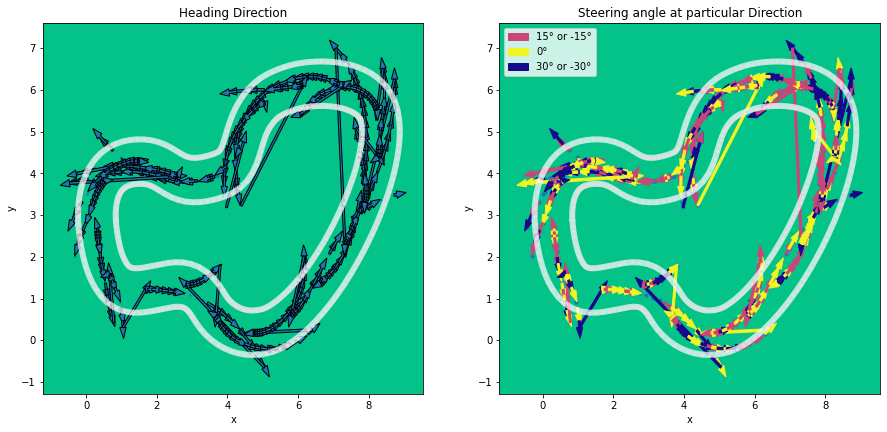

<Figure size 432x288 with 0 Axes>

In [230]:
fig = plt.figure(figsize=(16, 10))
#PlottingUtils.plot_grid_world
PlottingUtils.plot_grid_world(df, track,
        graphed_value='speed',
        min_progress=None,
        ax=None,
        points_gap=1,
        heading_arrow=True)

In [ ]:
steering.plot_graph(df)

In [ ]:
class steering:
    def plot_graph(data):
        
        
        PlottingUtils.print_border(ax, track, color='cyan')
        
        fig.show()

In [218]:
# class steering(PlottingUtils):
    
#     def print_border(ax, track: Track, color='lightgrey'):
#         """Print track borders on the chart
#         Arguments:
#         ax - axes to plot borders on
#         track - the track info to plot
#         color - what color to plot the border in, default: lightgrey
#         """
#         line = LineString(track.center_line)
#         PlottingUtils._plot_coords(ax, line)
#         PlottingUtils._plot_line(ax, line, color)

#         line = LineString(track.inner_border)
#         PlottingUtils._plot_coords(ax, line)
#         PlottingUtils._plot_line(ax, line, color)

#         line = LineString(track.outer_border)
#         PlottingUtils._plot_coords(ax, line)
#         PlottingUtils._plot_line(ax, line, color)
#     def plot_selected_laps(sorted_idx, df, track: Track, section_to_plot="episode"):
#         """Plot n laps in the training, referenced by episode ids
#         Arguments:
#         sorted_idx - a datagram with ids to be plotted or a list of ids
#         df - a datagram with all data
#         track - track info for plotting
#         secton_to_plot - what section of data to plot - episode/iteration
#         """

#         ids = sorted_idx

#         if type(sorted_idx) is not list:
#             ids = sorted_idx[section_to_plot].unique().tolist()

#         n_laps = len(ids)

#         fig = plt.figure(n_laps, figsize=(12, n_laps * 10))
#         for i in range(n_laps):
#             idx = ids[i]

#             data_to_plot = df[df[section_to_plot] == idx]

#             ax = fig.add_subplot(n_laps, 1, i + 1)

#             ax.axis('equal')

        
            
            
#             PlottingUtils.print_border(ax, track, color='cyan')
        
#             PlottingUtils.print_border(ax, track, color='cyan')
#         line = LineString(track.center_line)
#         ax=px.line(line,"steering_angle",color="steering_angle")
        
#         #ax.plot()
#         ax.show()

#             #data_to_plot.plot.scatter('x', 'y', ax=ax, s=10, c='blue')

#         #plt.show()
#        # plt.clf()


In [222]:
#steering.plot_graph(data)

In [221]:
#steering.plot_selected_laps([12], df, track)

### Path taken in a particular episode

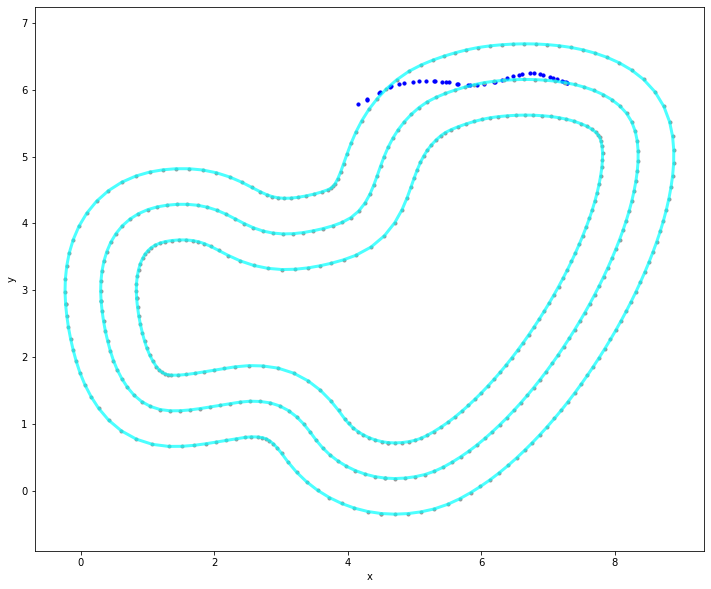

<Figure size 432x288 with 0 Axes>

In [175]:
episode_id = 12

pu.plot_selected_laps([episode_id], df, track)

In [138]:
help(PlottingUtils.plot_selected_laps)

Help on function plot_selected_laps in module __main__:

plot_selected_laps(sorted_idx, df, track:__main__.Track, section_to_plot='episode')
    Plot n laps in the training, referenced by episode ids
    Arguments:
    sorted_idx - a datagram with ids to be plotted or a list of ids
    df - a datagram with all data
    track - track info for plotting
    secton_to_plot - what section of data to plot - episode/iteration



### Path taken in a particular iteration

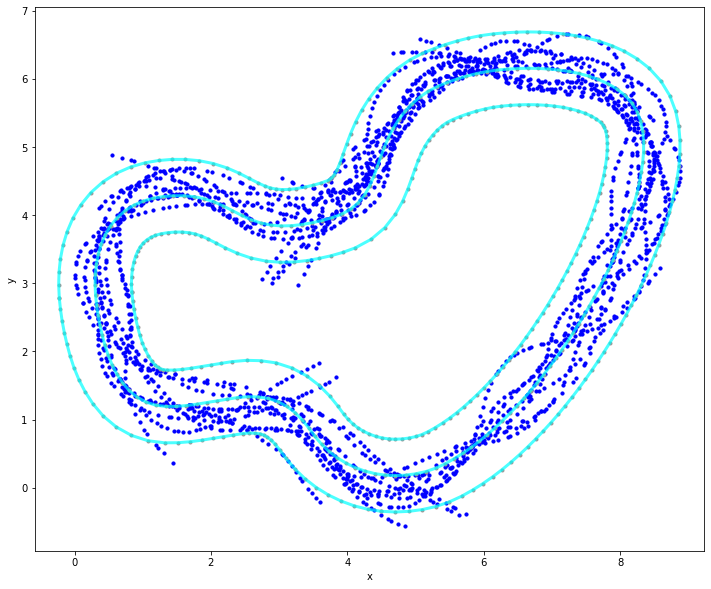

<Figure size 432x288 with 0 Axes>

In [176]:
iteration_id = 10

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

# Action breakdown per iteration and historgram for action distribution for each of the turns - reinvent track

This plot is useful to understand the actions that the model takes for any given iteration. Unfortunately at this time it is not fit for purpose as it assumes six actions in the action space and has other issues. It will require some work to get it to done but the information it returns will be very valuable.

This is a bit of an attempt to abstract away from the brilliant function in the original notebook towards a more general graph that we could use. It should be treated as a work in progress. The track_breakdown could be used as a starting point for a general track information object to handle all the customisations needed in methods of this notebook.

A breakdown track data needs to be available for it. If you cannot find it for the desired track, MAKEIT.

Currently supported tracks:

In [24]:
track_breakdown.keys()

dict_keys(['reinvent2018', 'london_loop'])

You can replace episode_ids with iteration_ids and make a breakdown for a whole iteration.

**Note: does not work for continuous action space (yet).** 

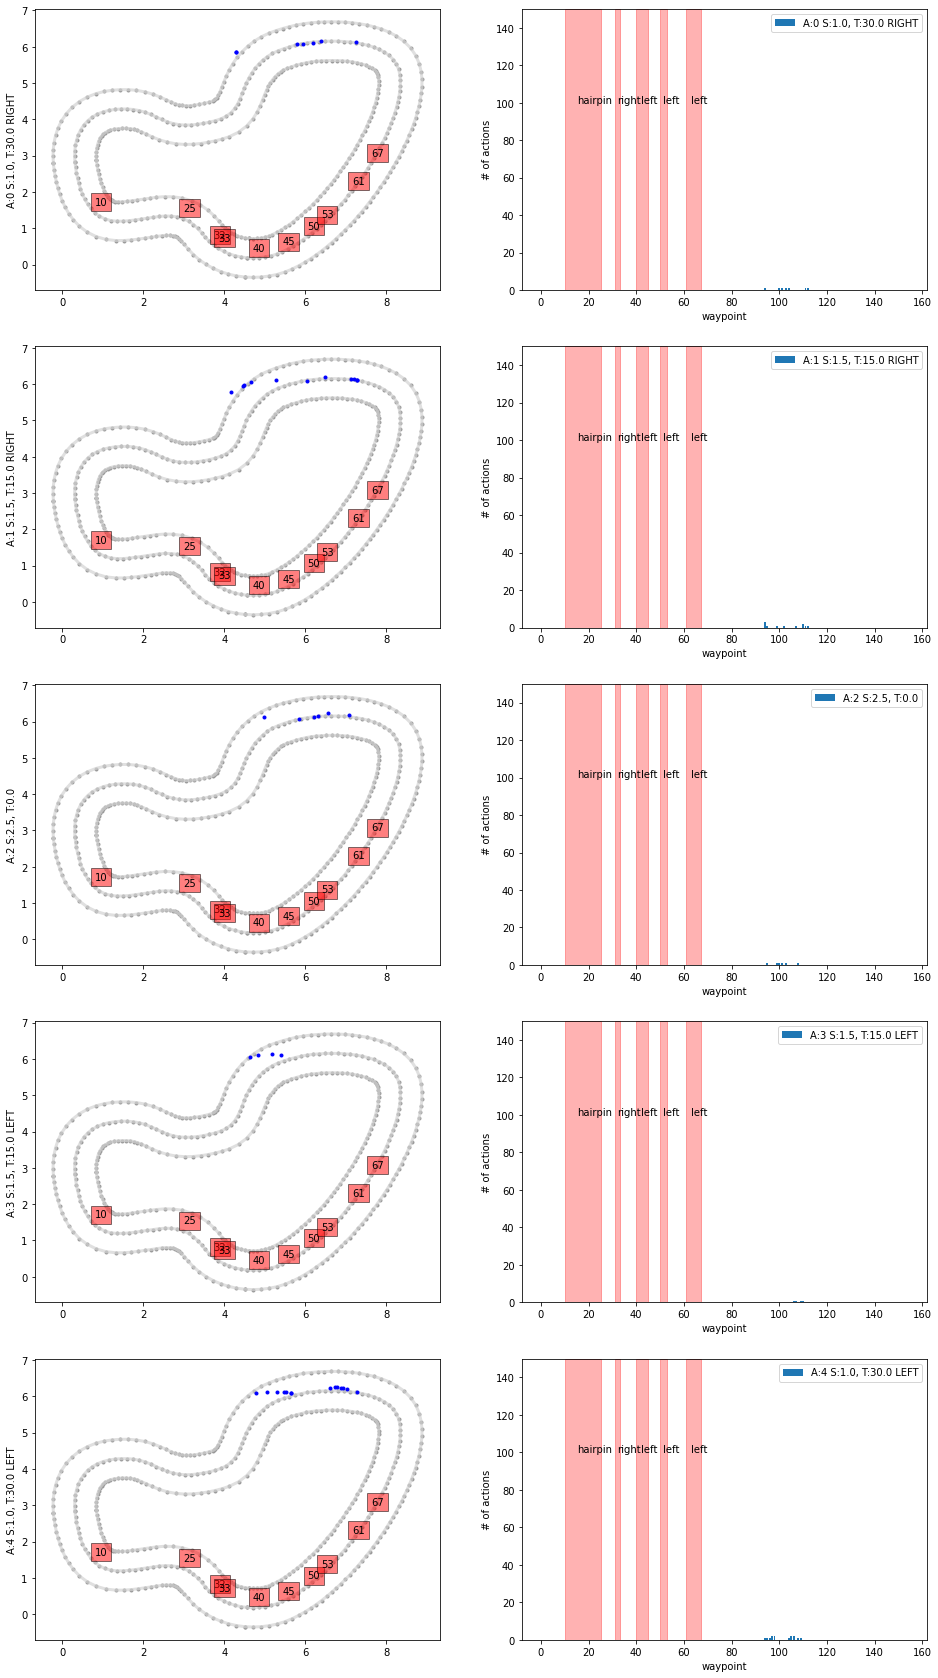

<Figure size 432x288 with 0 Axes>

In [178]:
abu.action_breakdown(df, track, track_breakdown=track_breakdown.get('reinvent2018'), episode_ids=[12])